# Naive Bayes classifier 
this code demonstrates an example use of the naive bayes classifier in dealing with multivariate data

the following python libraries are required to use this program: 
- numpy
- pandas
- sklearn
- yellowbrick
- matplotlib


#### import the dependencies

In [169]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel, SelectKBest, SequentialFeatureSelector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### read in the proprietary data as dataframe

In [170]:
data_sheet = pd.read_csv('SAKI Exercise 1 - Transaction Classification - Data Set.csv', sep=';')

#### define a function to derive features from a date

In [171]:
def extract_date_features(data_sheet, date_column_key):
    data_sheet[date_column_key] = pd.to_datetime(data_sheet[date_column_key],errors='coerce')
    return {date_column_key + '_day':data_sheet[date_column_key].dt.day,
            date_column_key + '_month':data_sheet[date_column_key].dt.month,
            date_column_key + '_year':data_sheet[date_column_key].dt.year,
            date_column_key  + '_quarter':data_sheet[date_column_key].dt.quarter,
            date_column_key  + '_dayofweek':data_sheet[date_column_key].dt.dayofweek,
            date_column_key  + '_dayofyear':data_sheet[date_column_key].dt.dayofyear,
            date_column_key  + '_weekofyear':data_sheet[date_column_key].dt.weekofyear,}

#### construct a word vectorizer and a function to deal with text

In [172]:
word_vectorizer = CountVectorizer()
# fit the word vectorizer with the variance of all string tokens in the passed column
word_vectorizer.fit(data_sheet['Verwendungszweck'])

def extract_word_count_features(data_sheet, verwendungs_key, word_vectorizer=word_vectorizer):
    verwendung_feature_names = word_vectorizer.get_feature_names()
    verwendung_vectors = word_vectorizer.transform(data_sheet[verwendungs_key]).toarray()
    verwendungs_df = pd.DataFrame(verwendung_vectors)
    verwendungs_df.columns = verwendung_feature_names
    return verwendungs_df

#### wrap the previous defined functions and prepare the feature list which is later being used to train the classifier 

In [173]:
def create_feature_list(data_sheet):
    # dataframe with features describing a date
    buchungs_data = extract_date_features(data_sheet,'Buchungstag' )
    buchungs_df = pd.DataFrame(buchungs_data)
    # dataframe with features describing a date
    valuta_data = extract_date_features(data_sheet,'Valutadatum' )
    valuta_df = pd.DataFrame(valuta_data)
    # dataframe where each cell describes the count of a word in the sample
    verwendungs_df = extract_word_count_features(data_sheet, 'Verwendungszweck')
    
    data_sheet['Betrag'] = pd.to_numeric(data_sheet['Betrag'], errors='coerce')
    
    X_train = pd.get_dummies(data_sheet[['Auftragskonto','Buchungstext', 'Beguenstigter/Zahlungspflichtiger','Kontonummer','BLZ', 'Waehrung']])
    # merge all dataframes 
    X_train = X_train.merge(buchungs_df, how='inner', left_index=True, right_index=True)
    X_train = X_train.merge(valuta_df, how='inner',left_index=True, right_index=True)
    X_train = X_train.merge(verwendungs_df, how='inner',left_index=True, right_index=True)
    X_train = X_train.merge(data_sheet['Betrag'], how='inner',left_index=True, right_index=True)                    
    X_train = X_train.fillna(0)
    return X_train

#### derive the training data and labels  

In [174]:
X_train = create_feature_list(data_sheet)
y_train = data_sheet['label']
print('Number of features =', X_train.shape[1])

Number of features = 522


#### train and evaluate the classifier with a cross-validation to get a first impression.

In [175]:
model = GaussianNB()
scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
print('Cross validation score = ', scores)
print('Mean validation score', np.mean(scores))

Cross validation score =  [0.30952381 0.30952381 0.30952381 0.38095238 0.53658537]
Mean validation score 0.3692218350754936


#### perform a sequential feature selection, select the 40% best 


In [176]:
n_features = int(X_train.shape[1]*0.4)
sfs = SequentialFeatureSelector(model, n_features_to_select = n_features)
print("Searching for the upper 40 % best features - This will probably take some minutes")
# fit the selector with the current training data 
sfs.fit(X_train, y_train)

X_train = sfs.transform(X_train)
print('Number of features after selection =', X_train.shape[1])

Searching for the upper 40 % best features - This will probably take some minutes
Number of features after selection = 208


#### evaluate a new model with the new selected features  

In [211]:
model = GaussianNB()
scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
print('Cross validation score after feature selection = ', scores)
print('Mean validation score', np.mean(scores))

Cross validation score after feature selection =  [1.         0.92857143 0.83333333 0.95238095 1.        ]
Mean validation score 0.9428571428571428


#### perform a more in depth validation (visualization might bug and several runs can be necessary in this cell)

the overall average accuracy from 20 was 0.9083333333333334


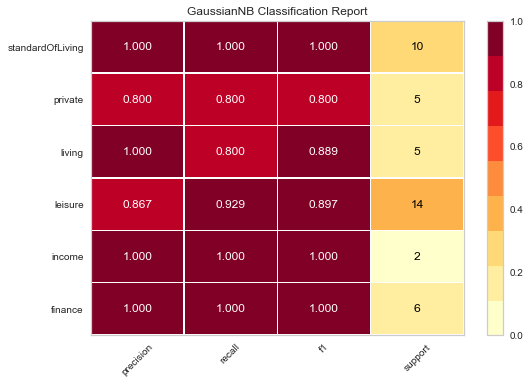

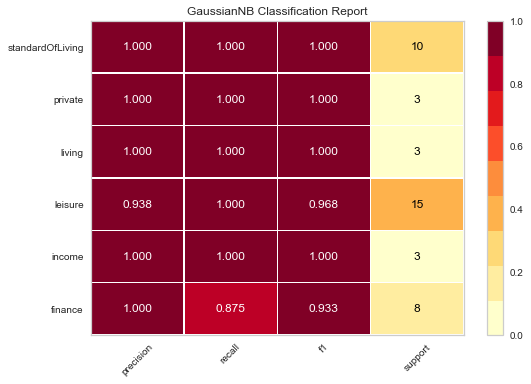

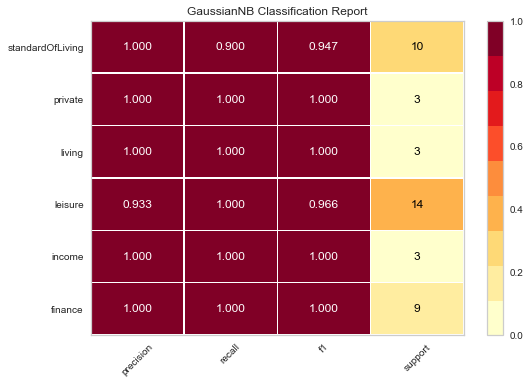

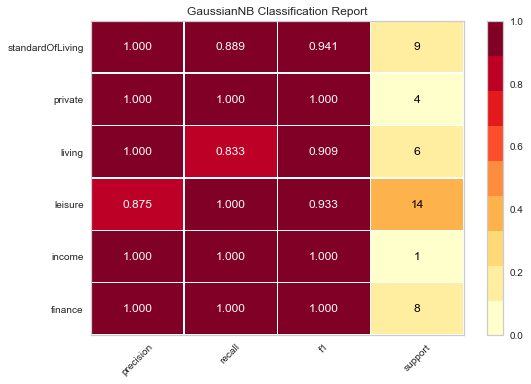

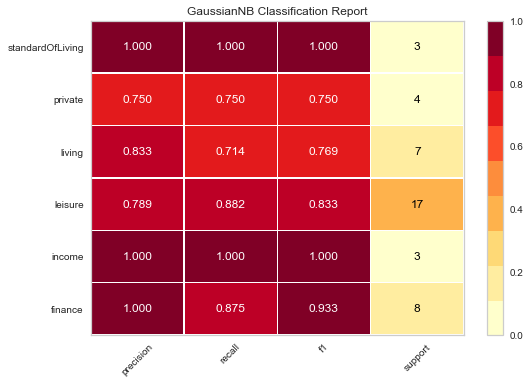

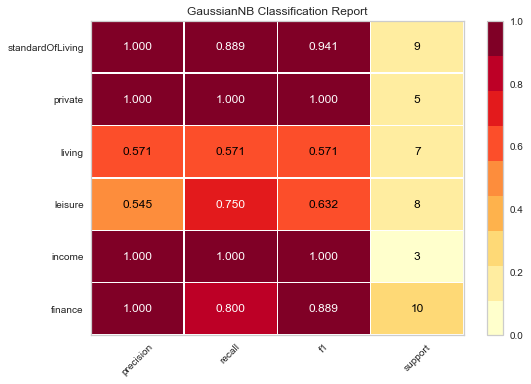

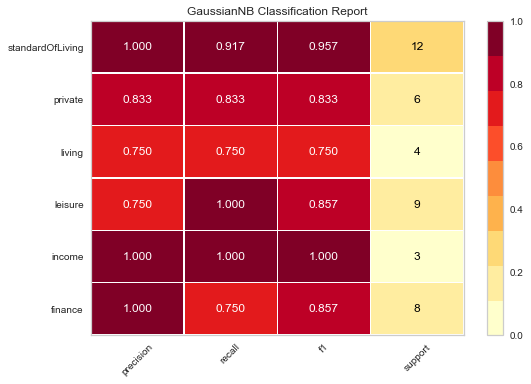

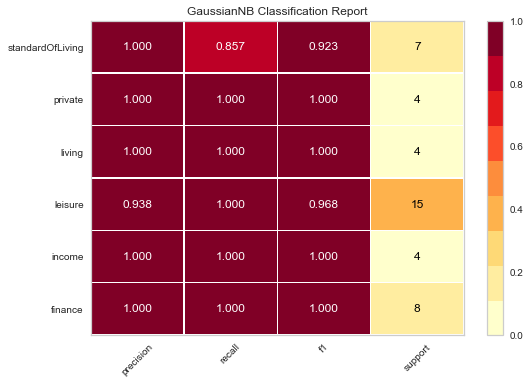

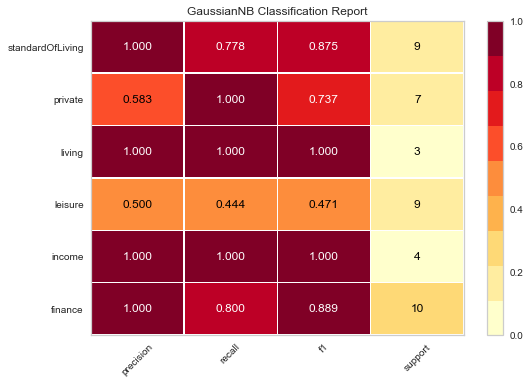

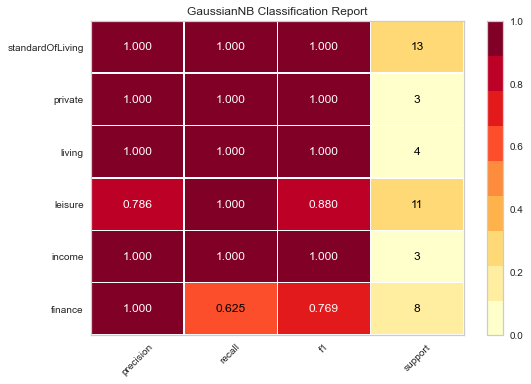

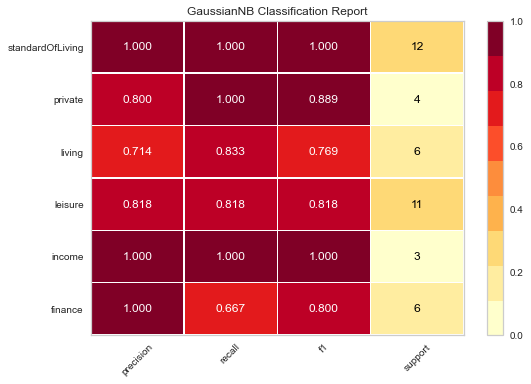

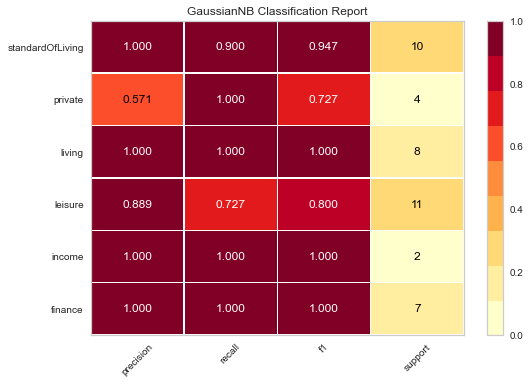

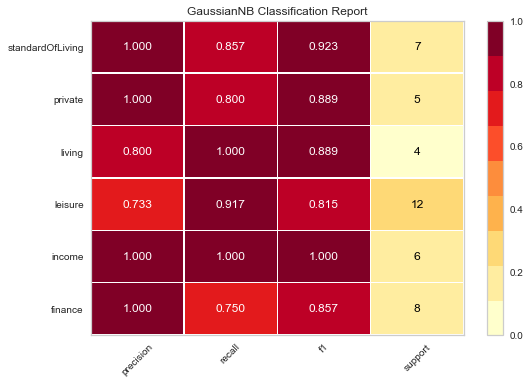

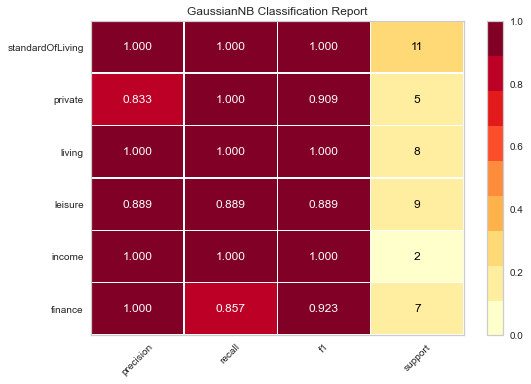

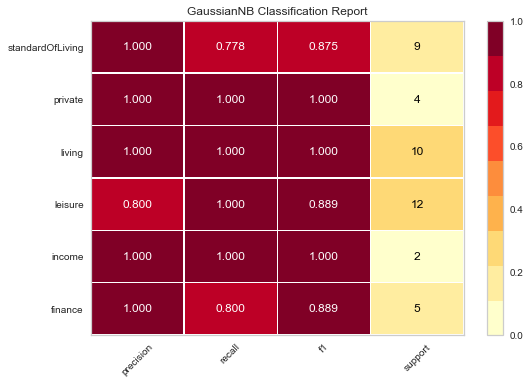

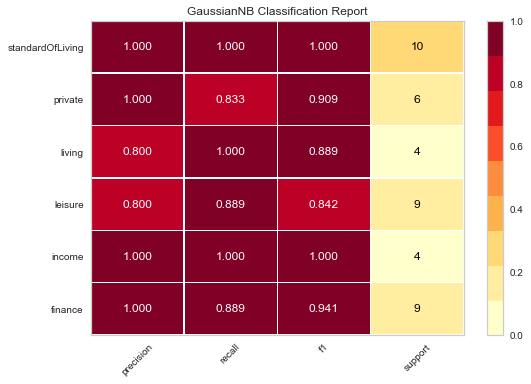

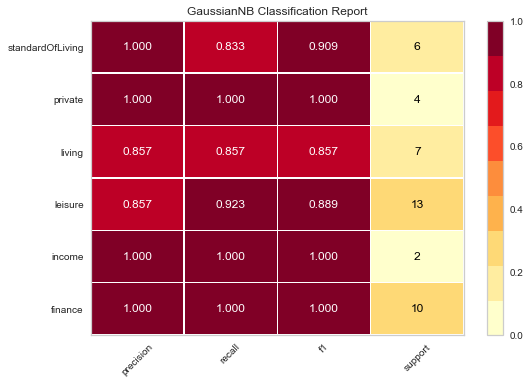

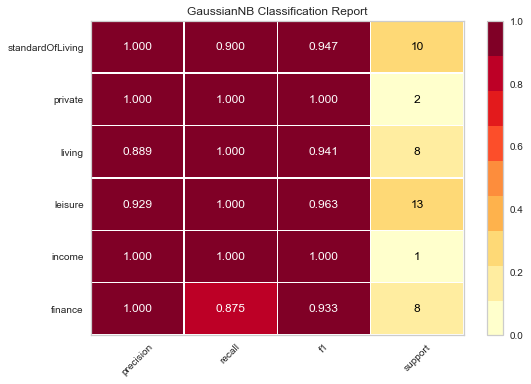

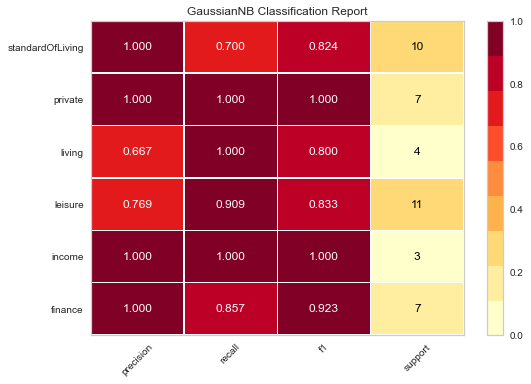

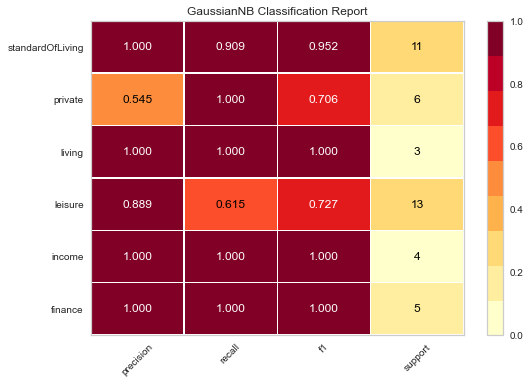

In [225]:
epochs = 20
scores = 0
for i in range(epochs):
    # perform a validation with randomly selected data
    # train with 90% and test with 10% of the dataset
    X_epoch_train, X_epoch_test, y_epoch_train, y_epoch_test = train_test_split(X_train, y_train.values.ravel(), test_size=0.2, shuffle=True)
    model = GaussianNB()
    fig = plt.figure(i)
    visualizer = ClassificationReport(model, support=True)
    visualizer.fit(X_epoch_train, y_epoch_train)
    scores += visualizer.score(X_epoch_test, y_epoch_test)
    visualizer.finalize()
    
print("the overall average accuracy from "+str(epochs)+ " was", scores/epochs)

#### train the classifier now with the whole data; reuse the model for future applications

In [200]:
model = GaussianNB()
X_train = create_feature_list(data_sheet)
X_train = sfs.transform(X_train)
y_train = pd.DataFrame(data_sheet['label'])

def predict_from_csv(csv_path, model=model, feature_selector = sfs):
    data_sheet = pd.read_csv(csv_path, sep=';')
    X = create_feature_list(data_sheet)
    X = sfs.transform(X)
    return model.predict(X)